#### Housekeeping

In [8]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets
from IPython.display import display

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

Updating the local database...
Done
Internal Structure of therpy has changed.
Now all functions (except for helper functions and imageio functions) are stored at one place therpy.funcs and available on root as tp.####.
If there are errors in your program, simply replace tp.module_name.func_name to tp.func_name.
If some function is not present there, it must be a helper function and can be accessed via tp.funcs._____
If you would like to go back to old therpy, use pip install therpy==0.2.5 


In [9]:
def dataset_counter(df, bg_param, bg_value, x='x', plot=False, ax=None, xlabel='x'):
    '''
    count the occurances of various x data points and bg points 
    '''
    # Count number of images 
    unique_x = np.unique(df[x])
    data_counts = np.array([np.sum(df[x][df[bg_param] != bg_value] == xi) for xi in unique_x])
    bg_counts = np.array([np.sum(df[x][df[bg_param] == bg_value] == xi) for xi in unique_x])
    dataset_counter = [unique_x, data_counts, bg_counts]
    
    # Plot
    if plot: 
        ax = plt.subplots(figsize=[15,4])[1] if (ax is None) else ax
        width = np.min(np.diff(dataset_counter[0]))*0.75 if (len(dataset_counter[0]) > 1) else 1
        ax.bar(dataset_counter[0], dataset_counter[1], width, label='Data')
        ax.bar(dataset_counter[0], dataset_counter[2], width, bottom=dataset_counter[1], label='BG')
        ax.legend()
        ax.set(xlabel = xlabel, ylabel='Shots')
        plt.tight_layout()
    
    return dataset_counter

In [10]:
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

In [11]:
# Specific Functions 

def sin_decay(x, wavelength=1, kappa=0, amplitude=1, phase=0, a0=0, a1=0, a2=0):
    return amplitude * np.exp(- x * kappa) * np.sin(twopi/wavelength * x - phase) + a0 + a1*x + a2*x**2

def calculate_data_sharedBG_usingCenter(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]

    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_parameter] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_data_sharedBG_usingTopEdge(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]
    
    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_parameter] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_shifted_app_center(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = (r.fitres_erf[0] + r.fitres_erf[1])/2
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean
        

def calculate_shifted_app_TopEdge(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = r.fitres_erf[1]
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean


# Load Data from Images 

In [174]:
df_all = pd.DataFrame()

In [175]:
# Relevant Parameters 
x_var_name = 'BoxShakeFreq'
x_var_label = 'freq (Hz)'
background_parameter = 'ShakingCycles'
background_value = 0
threshold_image_num = 1
image_use = 'A'

In [605]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all, x=x_var_name, params=import_params, 
                                  image_func=tp.Hybrid_Image, download=image_use, display=True)


Updating the local database...
Done

Total Number of Shots 88, Images 88


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,...,ShakeWait,HeatCycles,ShakingCycles,BoxShakeFreq,BoxShakeAmp,BoxShakeTime,SeqMode,x,total_atoms,use
name,,,,,,,,,,,,,,,,,,,,,
09-01-2017_16_26_55_TopA,0.0,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,70.0,0.0,190.0,0.3,0.0,None,190.0,513550,1.0
09-01-2017_16_28_43_TopA,1.8,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,70.0,0.0,190.0,0.3,0.0,None,190.0,507489,1.0
09-01-2017_16_29_37_TopA,2.7,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,70.0,0.0,190.0,0.3,0.0,None,190.0,481686,1.0


In [606]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, fudge=1.75, width=800, height=800, subsample=3, 
                  xsec_extension='poly0', xsec_slice_width=7, xsec_fit_range=1.0, radial_selection=0.9,)}

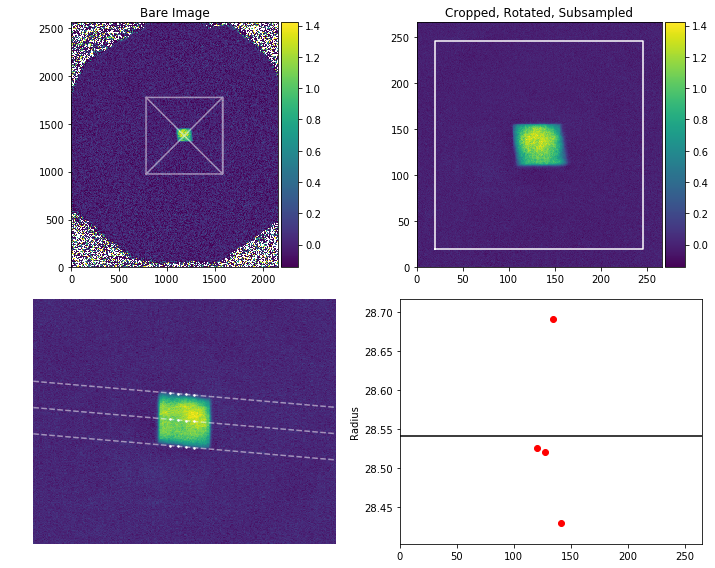

In [607]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))

WARNING! Background correction is larger than 10%. Imagename 09-01-2017_18_12_23_TopA

Total Images 88 ==> Good 83, Bad 5


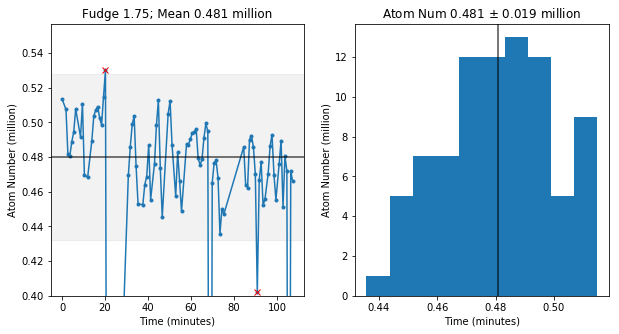

In [608]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.10, offset=0.0, display=True, plot=True)
ax[0].set(ylim=[0.4,None])
df = df_all[df_all.use]

[  70.    75.    77.5   80.    82.5   85.    87.5   90.    92.5   97.5
  100.   102.5  105.   107.5  110.   130.   140.   150.   155.   160.   165.
  170.   175.   180.   185.   190.   195.   200.   205.   210.   215.   220.
  230.   240.   250.   260.   270.   280.   290.   300.   310.   320.   330.
  340.   350.   360.   370.   380.   390.   400.   410.   420.   430.   440.
  450.   460.   470.   480.   490.   500.   510.   520.   530.   540.   560.
  570.   580.   590.   600.   610.   620.   630.   640.   650.   660.   670.
  680.   690.   710.   720. ]


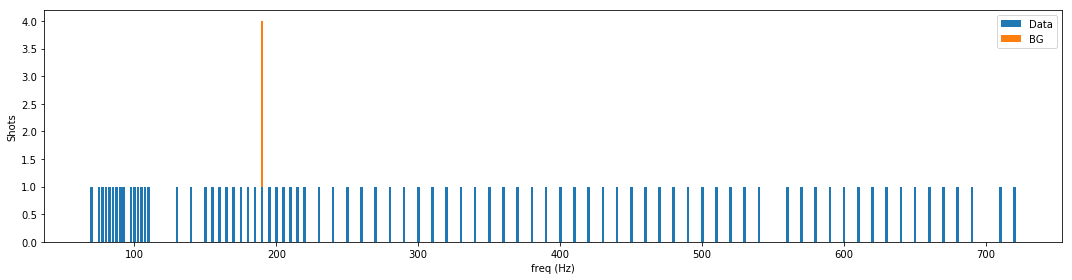

In [609]:
# Dataset Explorer 
ds_counter = dataset_counter(df=df, bg_param=background_parameter, bg_value=background_value, plot=True, xlabel=x_var_label)
print(np.unique(df.x.values))

In [610]:
# Compute df_data and dict_data 
# df_data = calculate_data_sharedBG_usingTopEdge(df)
# calculate_shifted_app_TopEdge(df, df_data)

df_data = calculate_data_sharedBG_usingCenter(df)
calculate_shifted_app_center(df, df_data)

dict_data = dict()


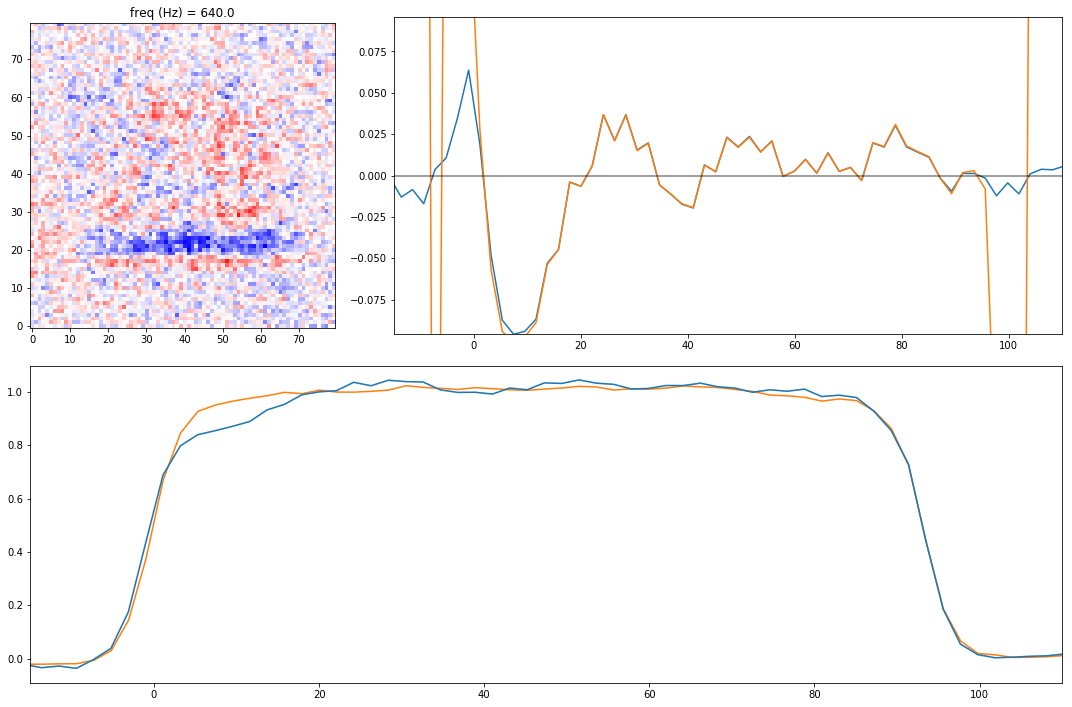

In [611]:
# Plot 2D Images and integrated profiles 
plot_xlim = [-15, 110]
def temp(test=np.random.randint(0, df_data.shape[0])):
    r = df_data.iloc[test]
    app = r['2D Delta rho']
    roi = tp.get_roi(app, width=80, height=80)
    clim = np.max(np.abs(app[roi])) * 1.0
    clim = [-clim, clim]
    fig = plt.figure(figsize=[15, 10])
    # Plot Image
    plt.subplot2grid((2,3),(0,0))
    plt.imshow(app[roi], origin=0, clim=clim, cmap='bwr')
    plt.title("{} = {}".format(x_var_label, r.name))
    # Plot Average delta rho 
    plt.subplot2grid((2,3),(0,1),colspan=2 )
    c = tp.Curve(r['Delta rho'].x * 1e6, r['Delta rho'].y / r.amp)
    ymax = np.max(np.abs(c.y))
    plt.plot(*c.data)
    c = tp.Curve(r['Delta rho / rho'].x * 1e6, r['Delta rho / rho'].y)
    plt.plot(*c.data)
    plt.ylim([-ymax, ymax])
    plt.axhline(0, c='k', alpha=0.5)
    plt.xlim(plot_xlim)
    # Plot All BG and Data nz 
    plt.subplot2grid((2,1),(1,0))
    for n in r['nz bg all']:
        plt.plot(n.x*1e6, n.y/r.amp, 'C1-', alpha=0.01)
    plt.plot(r['nz bg'].x*1e6, r['nz bg'].y / r.amp, 'C1-')
    for n in r['nz data all']:
        plt.plot(n.x*1e6, n.y/r.amp, 'C0-', alpha=0.2)
    plt.plot(r['nz data'].x*1e6, r['nz data'].y / r.amp, 'C0-')
    plt.xlim(plot_xlim)
    plt.tight_layout()
    plt.show()

if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

# Sonogram

In [612]:
# Saving Figures 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'Sonogram'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'09-01-2017_16_Sonogram\\'

## 2D Movies

In [613]:
# Compute movies 
z_lims = np.array([-10, 105]) * 1e-6
use = 'Delta rho'
movie = np.array([nz.trim(xlim=z_lims).y for nz in df_data[use]]).T / np.mean(df_data.amp)
movie = [df_data.index.values, df_data[use].iloc[0].trim(xlim=z_lims).x*1e6, movie]

In [614]:
# Compute FT 
L = np.mean(df_data.length) * 1e6
kscale = np.pi/L
k = np.arange(0, 15 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(movie[1], movie[2][:, i], k)[1] for i in range(movie[0].size)]).T
ft_real = [movie[0], k/kscale, np.real(ft)]
ft_imag = [movie[0], k/kscale, np.imag(ft)]
ft_abs = [movie[0], k/kscale, np.abs(ft)]

In [615]:
# Plot Prep 
clim_movie = np.max(np.abs(movie[2])) * 0.8
clim_ft = np.max(np.abs(ft_abs[2])) * 0.5

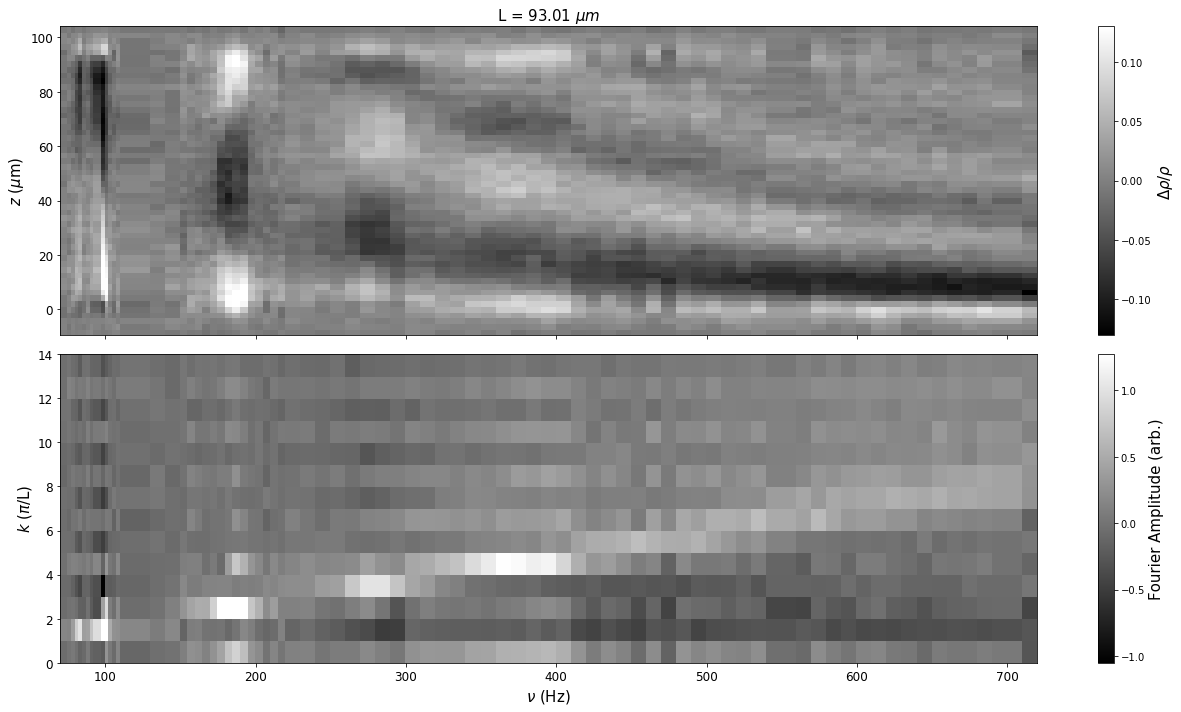

In [616]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='gray', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$', fontsize=15)
plt.sca(ax[1])
plt.pcolor(*ft_real, cmap='gray', linewidth=0, vmax=clim_ft)
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label='Fourier Amplitude (arb.)', fontsize=15)
fig.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v1.pdf')

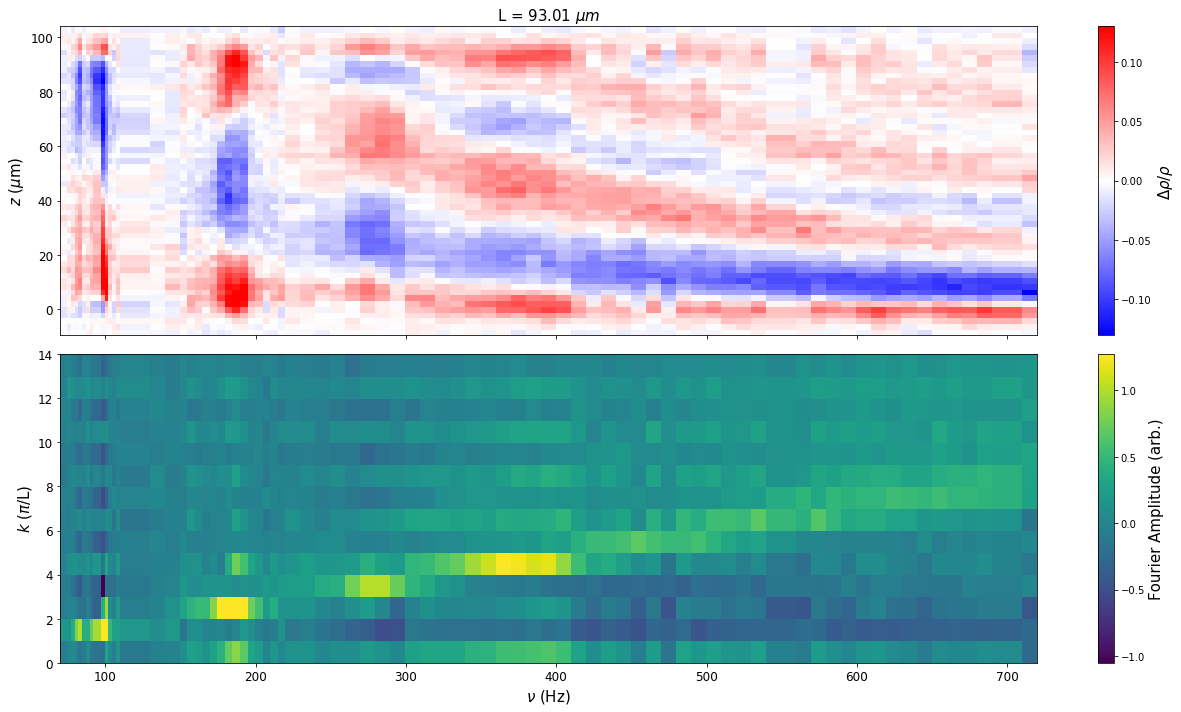

In [617]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$', fontsize=15)
plt.sca(ax[1])
plt.pcolor(*ft_real, cmap='viridis', linewidth=0, vmax=clim_ft)
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label='Fourier Amplitude (arb.)', fontsize=15)
fig.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v2.pdf')

## Lorentzian Fits 

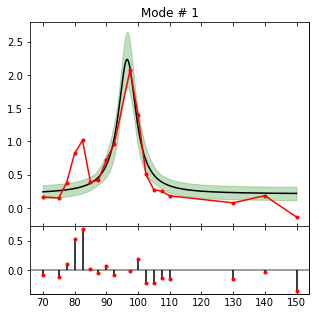

In [627]:
# Lorentzian Fits 
mode_num = np.array([1,2,3,4,5])
mode_fits = []
ft = ft_real 
ref_freq_guess = 100
gamma_guess = mode_num * 5
fit_lims = {'1' : [0, 150], '2':[120, 250], '3':[160, 390], '4':[250, 550], '5':[200,600], '6' : [0, 1000], '7':[200,700]}
# fit_lims = dict()

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1, offset=0, )
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

# Slider plot 
def temp(test = 0):
    ax = mode_fits[test].plot(fiterrors=True)
    ax[0].set_title('Mode # {}'.format(mode_num[test]))
    plt.sca(ax[0])
    if savefig.value: plt.savefig(suffix + 'SampleFits_Mode{}.pdf'.format(mode_num[test]))
    plt.show()
w = ipywidgets.interact(temp, test=(0, len(mode_num)-1))

In [628]:
# Extract Data 
modes = pd.DataFrame()
modes['mode #'] = mode_num
modes['k (1/m)'] = mode_num * kscale * 1e6
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode #']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode #']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['FWHM (Hz)'] = [cf['gamma'] for cf in mode_fits]
modes['FWHM (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['FWHM (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['FWHM (Hz) error'] * twopi
modes['FT amplitude (arb.)'] = [cf['amp'] for cf in mode_fits]

modes

,mode #,k (1/m),f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,FWHM (Hz),FWHM (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (arb.)
0,1,33776.991650,96.578790,0.697497,96.578790,0.697497,606.822433,4.382502,6.832137,1.794364,42.927584,11.274320,2.022932
1,2,67553.983299,182.970335,0.520094,91.485167,0.260047,1149.636520,3.267846,20.821701,2.086850,130.826604,13.112064,2.505235
2,3,101330.974949,273.937799,1.521222,91.312600,0.507074,1721.201954,9.558120,47.239287,6.031134,296.813195,37.894729,1.067903
3,4,135107.966599,364.824816,2.015028,91.206204,0.503757,2292.261923,12.660796,96.468020,10.228370,606.126447,64.266744,1.377357
4,5,168884.958249,454.270444,2.169143,90.854089,0.433829,2854.265381,13.629128,124.403634,10.031654,781.651083,63.030739,0.698556


In [629]:
# Save Data 
if savefig.value: modes.to_excel(suffix + 'FTLorentzianFits_Data.xlsx')

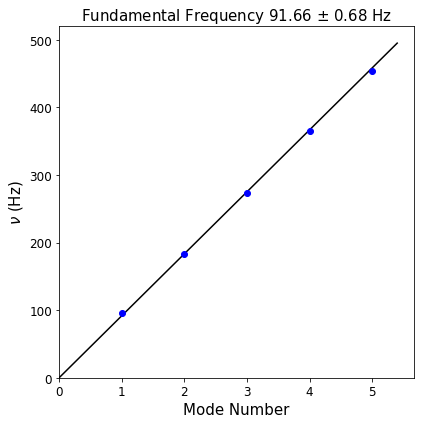

In [630]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode #'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode #'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode #'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'FundamentalFrequency_v1.pdf')

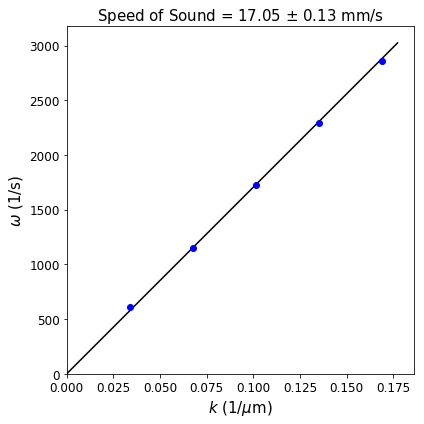

In [631]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
dict_data['speed fit'] = cf
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'Dispersion Relation_v1.pdf')

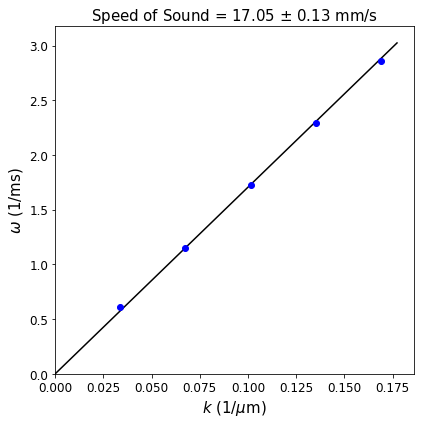

In [632]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, info=False, plot=False)
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/ms)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'Dispersion Relation_v2.pdf')

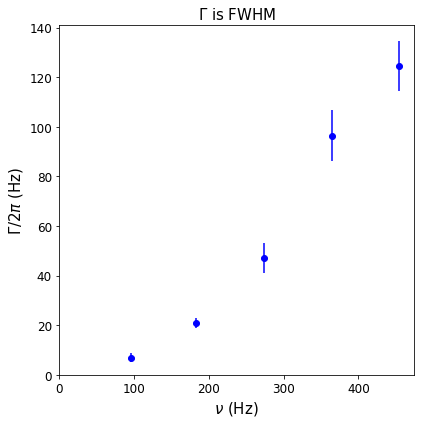

In [633]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['FWHM (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v1.pdf')

    FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
a2  0.000101  0.000004  None      1        -inf         inf   3.559222


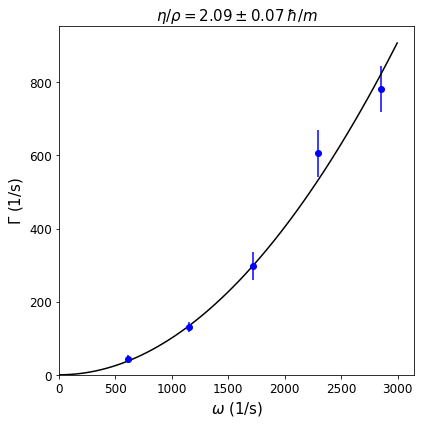

In [634]:
# Plot Gamma vs Omega 
cf = tp.curve_fit(lambda x, a2=0: a2*x**2, [1], modes['w (1/s)'], modes['gamma (1/s)'], modes['gamma (1/s) error'], info=True)
speed = dict_data['speed fit'][0] * 1e-6
eta_rho = [3/4 * cf[0] * speed**2 * cst.mass / cst.hbar, 3/4 * cf.fe[0] * speed**2 * cst.mass / cst.hbar]
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['w (1/s)'], modes['gamma (1/s)'], xerr=modes['w (1/s) error'], yerr=modes['gamma (1/s) error'], fmt='bo')
xp = np.linspace(0, cf.x.max()*1.05, 100)
plt.plot(xp, cf(xp), 'k-')
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ (1/s)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar / m$'.format(*eta_rho), fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v2.pdf')

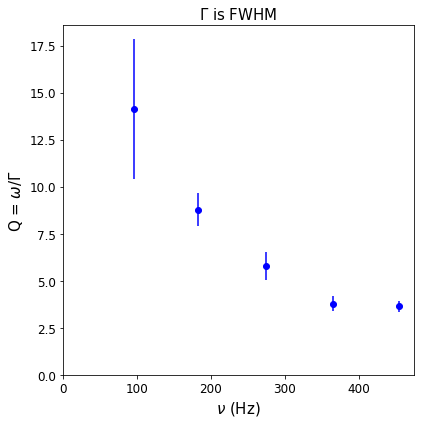

In [635]:
# Plot Q vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['f (Hz)']/modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], 
             yerr=np.sqrt((modes['f (Hz) error']/modes['FWHM (Hz)'])**2 + (modes['FWHM (Hz) error'] * modes['f (Hz)']/modes['FWHM (Hz)']**2)**2), fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'Q = $\omega / \Gamma $', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'QVsFreq_v1.pdf')

# Time Evolution

In [ ]:
c = 17
f = np.arange(500, 50, 1200)